In [25]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from tpot import TPOTClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost

from sklearn.metrics import roc_auc_score
import scikitplot as skplt
from sklearn.model_selection import train_test_split

%matplotlib inline

In [26]:
#valores estaticos
TEST_SIZE=0.20
RANDOM_STATE=42

In [27]:
df = pd.read_csv("../../data/processed/train/m1.0 - churn estricto - 6m.N.polizaXmes y Info.Cliente.M.Pago.csv", index_col="Unnamed: 0")
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 875419 entries, 1690 to 21260067
Data columns (total 56 columns):
6m                                875419 non-null int64
5m                                875419 non-null int64
4m                                875419 non-null int64
3m                                875419 non-null int64
2m                                875419 non-null int64
1m                                875419 non-null int64
edad_r                            875419 non-null int64
GENDER_F                          875419 non-null int64
GENDER_M                          875419 non-null int64
MARITAL_STATUS_Casado             875419 non-null int64
MARITAL_STATUS_Conviv             875419 non-null int64
MARITAL_STATUS_Divorciado         875419 non-null int64
MARITAL_STATUS_No Corresp         875419 non-null int64
MARITAL_STATUS_Separado           875419 non-null int64
MARITAL_STATUS_Soltero            875419 non-null int64
MARITAL_STATUS_Union Civ          875419 non

In [28]:
#distrib de churn
np.sum(df["Churn"]) / len(df)

0.030603630947009373

# Muestra random

In [29]:
msk = np.random.rand(len(df)) < 0.6

In [30]:
RANDOM_STATE=42
size = 0.6
"""
from sklearn.model_selection import StratifiedShuffleSplit


sss = StratifiedShuffleSplit(n_splits=1, test_size=size, random_state=RANDOM_STATE)
for train_index, val_index in sss.split(X,y):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

"""

'\nfrom sklearn.model_selection import StratifiedShuffleSplit\n\n\nsss = StratifiedShuffleSplit(n_splits=1, test_size=size, random_state=RANDOM_STATE)\nfor train_index, val_index in sss.split(X,y):\n    X_train, X_val = X[train_index], X[val_index]\n    y_train, y_val = y[train_index], y[val_index]\n\n'

In [31]:
df = df[msk]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 525325 entries, 1690 to 21179943
Data columns (total 56 columns):
6m                                525325 non-null int64
5m                                525325 non-null int64
4m                                525325 non-null int64
3m                                525325 non-null int64
2m                                525325 non-null int64
1m                                525325 non-null int64
edad_r                            525325 non-null int64
GENDER_F                          525325 non-null int64
GENDER_M                          525325 non-null int64
MARITAL_STATUS_Casado             525325 non-null int64
MARITAL_STATUS_Conviv             525325 non-null int64
MARITAL_STATUS_Divorciado         525325 non-null int64
MARITAL_STATUS_No Corresp         525325 non-null int64
MARITAL_STATUS_Separado           525325 non-null int64
MARITAL_STATUS_Soltero            525325 non-null int64
MARITAL_STATUS_Union Civ          525325 non

In [32]:
#distrib de churn
np.sum(df["Churn"]) / len(df)

0.030756198543758627

# split data set

In [33]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [35]:
print("train: {} - test: {}".format(len(X_train), len(X_test)))

train: 420260 - test: 105065


In [36]:
#distrib de churn
np.sum(y_train) / len(y_train)

0.030716699186218055

In [37]:
X_train.head()

,6m,5m,4m,3m,2m,1m,edad_r,GENDER_F,GENDER_M,MARITAL_STATUS_Casado,...,CITY_SANTIAGO DEL ESTERO,CITY_TIERRA DEL FUEGO,CITY_TUCUMAN,ModoPago_BA,ModoPago_CC,ModoPago_Mix,ModoPago_PP,ModoPago_SJ,ModoPago_TA,ModoPago_TM
19501032,1,1,1,1,1,1,2,0,1,0,...,0,0,0,0,0,1,0,0,0,0
16108766,0,0,0,0,0,0,3,0,1,0,...,0,0,0,0,1,0,0,0,0,0
1131657,2,2,2,2,2,1,4,0,1,1,...,0,0,0,0,0,1,0,0,0,0
4224898,1,1,1,1,1,2,5,0,1,1,...,0,0,0,0,0,1,0,0,0,0
12819289,1,1,1,1,1,0,3,0,1,0,...,0,0,1,0,0,1,0,0,0,0


# Modelo 1: Simple Random Forest

In [38]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

In [39]:
#modelo sin optimizar de prueba
class_weight = dict({0:1, 1:30})
clf = ExtraTreesClassifier(class_weight=class_weight,
                            criterion='gini', max_depth=None, max_features='auto',
                            max_leaf_nodes=None, min_impurity_decrease=0.0,
                            min_impurity_split=None, min_samples_leaf=20,
                            min_samples_split=6, min_weight_fraction_leaf=0.0,
                            n_estimators=1001,
                            n_jobs=-1, random_state=RANDOM_STATE)

clf.fit(X_train, y_train)


ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 30},
           criterion='gini', max_depth=None, max_features='auto',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=20,
           min_samples_split=6, min_weight_fraction_leaf=0.0,
           n_estimators=1001, n_jobs=-1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

Test set roc auc score for best params: 0.823 


/home/seba/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


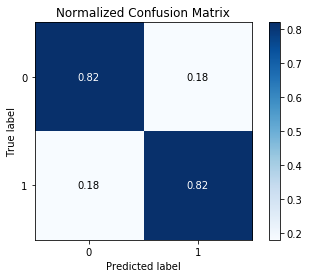

In [40]:
y_pred = clf.predict(X_test)

print('Test set roc auc score for best params: %.3f ' % roc_auc_score(y_test, y_pred))

skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)

In [41]:
#evaluación contra el testeo externo
df_testo_ext = pd.read_csv("../../data/processed/testeo/m1.0 - churn estricto - 6m.N.polizaXmes y Info.Cliente.M.Pago.csv", index_col="Unnamed: 0")
df_testo_ext.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 1690 to 21260067
Data columns (total 56 columns):
6m                                50000 non-null int64
5m                                50000 non-null int64
4m                                50000 non-null int64
3m                                50000 non-null int64
2m                                50000 non-null int64
1m                                50000 non-null int64
Churn                             50000 non-null int64
edad_r                            50000 non-null int64
GENDER_F                          50000 non-null int64
GENDER_M                          50000 non-null int64
MARITAL_STATUS_Casado             50000 non-null int64
MARITAL_STATUS_Conviv             50000 non-null int64
MARITAL_STATUS_Divorciado         50000 non-null int64
MARITAL_STATUS_No Corresp         50000 non-null int64
MARITAL_STATUS_Separado           50000 non-null int64
MARITAL_STATUS_Soltero            50000 non-null int64
MARIT

In [42]:
X_testo_ext = df_testo_ext.drop("Churn", axis=1)
y_testeo_ext = df_testo_ext["Churn"]

In [43]:
y_pred_testeo_ext = clf.predict(X_testo_ext)
roc_auc_score(y_testeo_ext, y_pred_testeo_ext)

0.6919417824882883

/home/seba/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


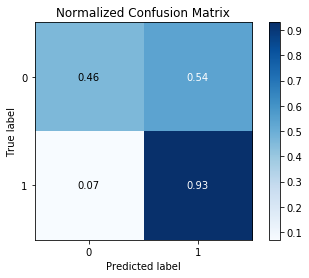

In [44]:
skplt.metrics.plot_confusion_matrix(y_testeo_ext, y_pred_testeo_ext, normalize=True)

# Optimizando parametros

In [15]:
#param_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
param_range = [6, 8, 12]
#param_range_fl = [1.0, 0.5, 0.1]
class_weight_range = [{0:1, 1:20},{0:1, 1:25}]
#param_range_fl = np.power(10., np.arange(-4, 4))


#'clf__max_depth': param_range,
grid_params_rf = [{'clf__criterion': ['gini', 'entropy'],
		'clf__min_samples_leaf': param_range,
		'clf__min_samples_split': param_range,
    'clf__class_weight' : class_weight_range}]

pipe_rf = Pipeline([('scl', StandardScaler()),
                    ('clf', ExtraTreesClassifier(random_state=RANDOM_STATE))])

# Construct grid searches
jobs = -1
#scoring = "roc_auc"
#scoring = "roc_auc" #http://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}
cv = 3

#refit=True, entrena el mejor modelo obtenido con todo el dataset! :D
#verbose => mientras mayor el número, más info va mostrando.
gs_rf = GridSearchCV(estimator=pipe_rf,
            param_grid=grid_params_rf,
            scoring=scoring,
            cv=cv,
            verbose=2,
            refit="AUC",
            n_jobs=jobs)
gs_rf

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0,...stimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'clf__criterion': ['gini', 'entropy'], 'clf__min_samples_leaf': [6, 8, 12], 'clf__min_samples_split': [6, 8, 12], 'clf__class_weight': [{0: 1, 1: 20}, {0: 1, 1: 25}]}],
       pre_dispatch='2*n_jobs', refit='AUC', return_train_score='warn',
       scoring={'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)},
       verbose=2)

In [16]:
# Fit grid search	
gs_rf.fit(X_train, y_train)
# Best params
print('Best params: %s' % gs_rf.best_params_)
# Best training data roc auc
print('Best training roc auc: %.3f' % gs_rf.best_score_)
# Predict on test data with best params
y_pred_gs_rf = gs_rf.predict(X_test)
# Test data roc auc of model with best params
print('Test set roc auc score for best params: %.3f ' % roc_auc_score(y_test, y_pred_gs_rf))

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] clf__class_weight={0: 1, 1: 20}, clf__criterion=gini, clf__min_samples_leaf=6, clf__min_samples_split=6 
[CV] clf__class_weight={0: 1, 1: 20}, clf__criterion=gini, clf__min_samples_leaf=6, clf__min_samples_split=6 
[CV] clf__class_weight={0: 1, 1: 20}, clf__criterion=gini, clf__min_samples_leaf=6, clf__min_samples_split=6 
[CV] clf__class_weight={0: 1, 1: 20}, clf__criterion=gini, clf__min_samples_leaf=6, clf__min_samples_split=8 
[CV]  clf__class_weight={0: 1, 1: 20}, clf__criterion=gini, clf__min_samples_leaf=6, clf__min_samples_split=6, total=  16.9s
[CV] clf__class_weight={0: 1, 1: 20}, clf__criterion=gini, clf__min_samples_leaf=6, clf__min_samples_split=8 
[CV]  clf__class_weight={0: 1, 1: 20}, clf__criterion=gini, clf__min_samples_leaf=6, clf__min_samples_split=6, total=  18.3s
[CV] clf__class_weight={0: 1, 1: 20}, clf__criterion=gini, clf__min_samples_leaf=6, clf__min_samples_split=8 
[CV]  clf__class_weight={0: 

[CV] clf__class_weight={0: 1, 1: 20}, clf__criterion=entropy, clf__min_samples_leaf=8, clf__min_samples_split=6 


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.8min


[CV]  clf__class_weight={0: 1, 1: 20}, clf__criterion=entropy, clf__min_samples_leaf=6, clf__min_samples_split=12, total=  20.0s
[CV] clf__class_weight={0: 1, 1: 20}, clf__criterion=entropy, clf__min_samples_leaf=8, clf__min_samples_split=6 
[CV]  clf__class_weight={0: 1, 1: 20}, clf__criterion=entropy, clf__min_samples_leaf=6, clf__min_samples_split=12, total=  20.7s
[CV] clf__class_weight={0: 1, 1: 20}, clf__criterion=entropy, clf__min_samples_leaf=8, clf__min_samples_split=6 
[CV]  clf__class_weight={0: 1, 1: 20}, clf__criterion=entropy, clf__min_samples_leaf=6, clf__min_samples_split=12, total=  22.1s
[CV] clf__class_weight={0: 1, 1: 20}, clf__criterion=entropy, clf__min_samples_leaf=8, clf__min_samples_split=8 
[CV]  clf__class_weight={0: 1, 1: 20}, clf__criterion=entropy, clf__min_samples_leaf=8, clf__min_samples_split=6, total=  21.0s
[CV] clf__class_weight={0: 1, 1: 20}, clf__criterion=entropy, clf__min_samples_leaf=8, clf__min_samples_split=8 
[CV]  clf__class_weight={0: 1, 1:

[CV] clf__class_weight={0: 1, 1: 25}, clf__criterion=gini, clf__min_samples_leaf=8, clf__min_samples_split=12 
[CV]  clf__class_weight={0: 1, 1: 25}, clf__criterion=gini, clf__min_samples_leaf=8, clf__min_samples_split=8, total=  19.4s
[CV] clf__class_weight={0: 1, 1: 25}, clf__criterion=gini, clf__min_samples_leaf=12, clf__min_samples_split=6 
[CV]  clf__class_weight={0: 1, 1: 25}, clf__criterion=gini, clf__min_samples_leaf=8, clf__min_samples_split=12, total=  18.5s
[CV] clf__class_weight={0: 1, 1: 25}, clf__criterion=gini, clf__min_samples_leaf=12, clf__min_samples_split=6 
[CV]  clf__class_weight={0: 1, 1: 25}, clf__criterion=gini, clf__min_samples_leaf=8, clf__min_samples_split=12, total=  19.3s
[CV] clf__class_weight={0: 1, 1: 25}, clf__criterion=gini, clf__min_samples_leaf=12, clf__min_samples_split=6 
[CV]  clf__class_weight={0: 1, 1: 25}, clf__criterion=gini, clf__min_samples_leaf=8, clf__min_samples_split=12, total=  18.4s
[CV] clf__class_weight={0: 1, 1: 25}, clf__criterion=

[CV]  clf__class_weight={0: 1, 1: 25}, clf__criterion=entropy, clf__min_samples_leaf=12, clf__min_samples_split=8, total=  20.0s
[CV] clf__class_weight={0: 1, 1: 25}, clf__criterion=entropy, clf__min_samples_leaf=12, clf__min_samples_split=12 
[CV]  clf__class_weight={0: 1, 1: 25}, clf__criterion=entropy, clf__min_samples_leaf=12, clf__min_samples_split=8, total=  20.1s
[CV] clf__class_weight={0: 1, 1: 25}, clf__criterion=entropy, clf__min_samples_leaf=12, clf__min_samples_split=12 
[CV]  clf__class_weight={0: 1, 1: 25}, clf__criterion=entropy, clf__min_samples_leaf=12, clf__min_samples_split=12, total=  17.6s
[CV]  clf__class_weight={0: 1, 1: 25}, clf__criterion=entropy, clf__min_samples_leaf=12, clf__min_samples_split=8, total=  21.2s
[CV]  clf__class_weight={0: 1, 1: 25}, clf__criterion=entropy, clf__min_samples_leaf=12, clf__min_samples_split=12, total=  20.2s
[CV]  clf__class_weight={0: 1, 1: 25}, clf__criterion=entropy, clf__min_samples_leaf=12, clf__min_samples_split=12, total= 

[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed: 11.5min finished


Best params: {'clf__class_weight': {0: 1, 1: 25}, 'clf__criterion': 'entropy', 'clf__min_samples_leaf': 12, 'clf__min_samples_split': 6}
Best training roc auc: 0.875
Test set roc auc score for best params: 0.812 


/home/seba/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


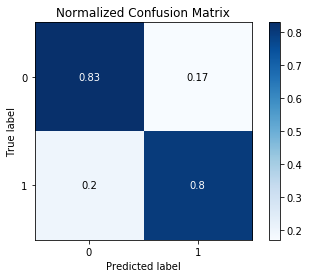

In [17]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred_gs_rf, normalize=True)

In [18]:
#evaluación contra el testeo externo
df_testo_ext = pd.read_csv("../../data/processed/testeo/m1.0 - churn estricto - 6m.N.polizaXmes y Info.Cliente.M.Pago.csv", index_col="Unnamed: 0")
df_testo_ext.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 1690 to 21260067
Data columns (total 56 columns):
6m                                50000 non-null int64
5m                                50000 non-null int64
4m                                50000 non-null int64
3m                                50000 non-null int64
2m                                50000 non-null int64
1m                                50000 non-null int64
Churn                             50000 non-null int64
edad_r                            50000 non-null int64
GENDER_F                          50000 non-null int64
GENDER_M                          50000 non-null int64
MARITAL_STATUS_Casado             50000 non-null int64
MARITAL_STATUS_Conviv             50000 non-null int64
MARITAL_STATUS_Divorciado         50000 non-null int64
MARITAL_STATUS_No Corresp         50000 non-null int64
MARITAL_STATUS_Separado           50000 non-null int64
MARITAL_STATUS_Soltero            50000 non-null int64
MARIT

In [19]:
X_testo_ext = df_testo_ext.drop("Churn", axis=1)
y_testeo_ext = df_testo_ext["Churn"]

In [20]:
X_testo_ext.head()

,6m,5m,4m,3m,2m,1m,edad_r,GENDER_F,GENDER_M,MARITAL_STATUS_Casado,...,CITY_SANTIAGO DEL ESTERO,CITY_TIERRA DEL FUEGO,CITY_TUCUMAN,ModoPago_BA,ModoPago_CC,ModoPago_Mix,ModoPago_PP,ModoPago_SJ,ModoPago_TA,ModoPago_TM
1690,0,0,0,0,0,0,5,0,1,1,...,0,0,0,0,1,0,0,0,0,0
5575,2,2,2,2,2,1,4,0,1,1,...,0,0,0,0,0,1,0,0,0,0
7968,2,2,2,2,2,2,0,0,1,1,...,0,0,0,0,1,0,0,0,0,0
9028,2,2,2,2,2,2,4,0,1,1,...,0,0,0,0,0,1,0,0,0,0
9860,1,1,1,1,1,0,4,0,1,0,...,0,0,0,0,0,1,0,0,0,0


In [21]:
clf = gs_rf.best_estimator_
clf

Pipeline(memory=None,
     steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 25},
           criterion='entropy', max_depth=None, max_features='auto',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_...estimators=10, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False))])

In [22]:
y_pred_testeo_ext = clf.predict(X_testo_ext)

In [23]:
roc_auc_score(y_testeo_ext, y_pred_testeo_ext)

0.6914003033446112

/home/seba/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


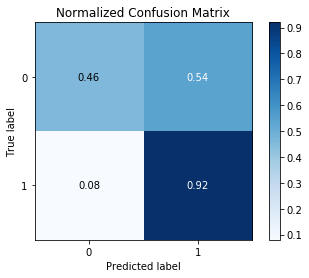

In [24]:
skplt.metrics.plot_confusion_matrix(y_testeo_ext, y_pred_testeo_ext, normalize=True)

In [22]:
gs_rf.best_estimator_

Pipeline(memory=None,
     steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 25},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity...stimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False))])

In [23]:
#bajando el modelo
from sklearn.externals import joblib

joblib.dump(clf, '../../models/M1.4.b - opt Modelo ExtraTreesClassifier (82-63) - Churn estricto- 6m.N.polizaXmes y Info.Cliente.M.Pago.pkl')

['../../models/M1.1 - Modelo RandomForest (0.-0.) - Churn estricto- 6m.N.polizaXmes y Info.Cliente.M.Pago.pkl']

# Realizando predicción para entregar

In [64]:
df_pred = pd.read_csv("../../data/processed/test_cliente/m1.0 - 6m.N.polizaXmes y Info.Cliente.M.Pago.csv", index_col="Unnamed: 0")
df_pred.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 1690 to 21260067
Data columns (total 55 columns):
6m                                50000 non-null int64
5m                                50000 non-null int64
4m                                50000 non-null int64
3m                                50000 non-null int64
2m                                50000 non-null int64
1m                                50000 non-null int64
edad_r                            50000 non-null int64
GENDER_F                          50000 non-null int64
GENDER_M                          50000 non-null int64
MARITAL_STATUS_Casado             50000 non-null int64
MARITAL_STATUS_Conviv             50000 non-null int64
MARITAL_STATUS_Divorciado         50000 non-null int64
MARITAL_STATUS_No Corresp         50000 non-null int64
MARITAL_STATUS_Separado           50000 non-null int64
MARITAL_STATUS_Soltero            50000 non-null int64
MARITAL_STATUS_Union Civ          50000 non-null int64
MARIT

In [65]:
y_pred_predFin  = gs_rf.best_estimator_.predict_proba(df_pred)

In [95]:
csv = pd.DataFrame()
csv["CUSTOMER_ID"] = df_pred.index.values
csv["PRED"] = pd.DataFrame(y_pred_predFin)[1]
csv.set_index("CUSTOMER_ID", inplace=True)
csv.head()

,CUSTOMER_ID,PRED
0,1690,0.006911
1,5575,0.096964
2,7968,0.134929
3,9028,0.035026
4,9860,0.010475


In [96]:
csv.to_csv("../../data/processed/prediccion_para_cliente/m1.4.b - predict - 6m.N.polizaXmes y Info.Cliente.M.Pago.csv")